In [3]:
import sys,os

import torch
import numpy as np

sys.path.append('..')

from modeling import SOFModel
from dataset.face_dataset import _campos2matrix

import util
from sklearn import mixture

_RENDERER = 'FC'
_ORTHO = False

_MODEL_PATH = '../checkpoints/epoch_0250_iter_050000.pth'
_OPT_CAM = False
_ORTHO = True
_TOT_NUM_INSTANCES = 221

focal = 36
cam_center =  np.asarray([0, 0, 4.5])
dpt_range = [2.0, 5.0]

_IMG_SIZE = 128
_OUT_SIZE = 128
_INTERP_STEPS = 20

_DEFAULT_CAM_INT = np.array(
    [[focal,0,_IMG_SIZE//2],
     [0,focal,_IMG_SIZE//2],
     [0,0,1]])

lookat = np.asarray([0, 0, 0.0])
cam_up = np.asarray([0.0, 1.0, 0.0])
_DEFAULT_CAM_POSE =  _campos2matrix(cam_center, lookat, cam_up)

torch.cuda.set_device(2)

model = SOFModel(num_instances=_TOT_NUM_INSTANCES,
                  latent_dim=256,
                  renderer=_RENDERER,
                  tracing_steps=10,
                  freeze_networks=True,
                  out_channels=20,
                  img_sidelength=_IMG_SIZE,
                  output_sidelength=_OUT_SIZE,
                  opt_cam=_OPT_CAM,
                  orthogonal=_ORTHO,
                 )

util.custom_load(model, path=_MODEL_PATH, discriminator=None,
                 overwrite_embeddings=False, overwrite_cam=True)

model.eval()
model.cuda()

[INIT embedding] variable.
[INIT renderer] FC, with renderer = FC


SOFModel(
  (latent_codes): Embedding(221, 256)
  (hyper_phi): HyperFC(
    (layers): ModuleList(
      (0): NewCls(
        (hyper_linear): HyperLinear(
          (hypo_params): FCBlock(
            (net): Sequential(
              (0): FCLayer(
                (net): Sequential(
                  (0): Linear(in_features=256, out_features=256, bias=True)
                  (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
                  (2): ReLU(inplace=True)
                )
              )
              (1): FCLayer(
                (net): Sequential(
                  (0): Linear(in_features=256, out_features=256, bias=True)
                  (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
                  (2): ReLU(inplace=True)
                )
              )
              (2): Linear(in_features=256, out_features=1024, bias=True)
            )
          )
        )
        (norm_nl): Sequential(
          (0): LayerNorm((256,), eps=1e-05, elementwise_a

interactive(children=(IntSlider(value=136, description='ins_id', max=220), FloatSlider(value=2.0, description=…

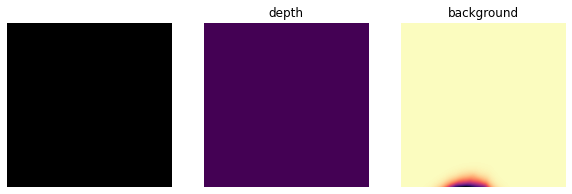

In [4]:
from utils.volRenderer import render_scene_cam, VolRender, _LABEL, _CMAP

from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, FloatSlider
import ipywidgets as widgets

import matplotlib.pyplot as plt


def render_dpt(ins_id, dpt, vis_cls):
    
    latent = model.get_embedding({'instance_idx': torch.LongTensor([ins_id]).squeeze().cuda()}).unsqueeze(0)
    
    out_img, out_seg, prob, dpt_map = render_scene_cam(
        model, latent, _DEFAULT_CAM_POSE, _DEFAULT_CAM_INT, _OUT_SIZE, dpt=dpt)
    
    figure=plt.figure(figsize=(10,5))
    plt.subplot(1, 3, 1)
    plt.imshow(out_img)
    plt.grid("off");
    plt.axis("off");
    
    plt.subplot(1, 3, 2)
    plt.title("depth")
    plt.imshow(dpt_map)
    plt.grid("off");
    plt.axis("off");
    
    plt.subplot(1, 3, 3)
    plt.title(_LABEL[vis_cls])
    plt.imshow(prob[:, :, vis_cls], cmap=plt.get_cmap('magma'))
    plt.grid("off");
    plt.axis("off");


dpt_slider = FloatSlider(min=dpt_range[0], max=dpt_range[1], step=0.005)
cls_slider = IntSlider(min=0, max=len(_LABEL)-1, step=1, value=0)
ins_slider = IntSlider(min=0, max=_TOT_NUM_INSTANCES-1, step=1, value=136)
    
interactive_plot = interactive(render_dpt, ins_id=ins_slider, dpt=dpt_slider, vis_cls=cls_slider)
output = interactive_plot.children[-1]
interactive_plot

In [ ]:
z = model.get_embedding({'instance_idx': torch.LongTensor([ins_slider.value]).squeeze().cuda()}).unsqueeze(0)
_OUT_SIZE = 512
renderer = VolRender(
    model, z, _DEFAULT_CAM_POSE, _DEFAULT_CAM_INT, dpt_range, 
    ortho=_ORTHO, level_set=-0.5, resolution=(_OUT_SIZE, _OUT_SIZE))


In [3]:
import imageio
from scipy.stats import norm
from dataset.face_dataset import _campos2matrix

remap_list = np.array([0,1,2,2,3,3,4,5,6,7,8,9,9,10,11,12,13,14,15,16]).astype('float')
def id_remap(seg):
    return remap_list[seg.astype('int')]

def vis_condition_img(img):
    part_colors = [[0, 0, 0], [127, 212, 255], [255, 255, 127], [255, 255, 170],#'skin',1 'eye_brow'2,  'eye'3
                    [240, 157, 240], [255, 212, 255], #'r_nose'4, 'l_nose'5
                    [31, 162, 230], [127, 255, 255], [127, 255, 255],#'mouth'6, 'u_lip'7,'l_lip'8
                    [0, 255, 85], [0, 255, 170], #'ear'9 'ear_r'10
                    [255, 255, 170],
                    [127, 170, 255], [85, 0, 255], [255, 170, 127], #'neck'11, 'neck_l'12, 'cloth'13
                    [212, 127, 255], [0, 170, 255],#, 'hair'14, 'hat'15
                    [255, 255, 0], [255, 255, 85], [255, 255, 170],
                    [255, 0, 255], [255, 85, 255], [255, 170, 255],
                    [0, 255, 255], [85, 255, 255], [170, 255, 255], [100, 150, 200]]
    H,W = img.shape
    condition_img_color = np.zeros((H,W,3)).astype('uint8')

    num_of_class = int(np.max(img))
    for pi in range(1, num_of_class + 1):
        index = np.where(img == pi)
        condition_img_color[index[0], index[1],:] = part_colors[pi]
    return condition_img_color


def render_spiral_path(cam_center,lookat,radii,src_latent,trgt_latent, directions=None):
    # ROTATE
    R = np.linalg.norm(cam_center-lookat) + radii[0]

    theta = []
    theta_range = [0.0, -0.45, 0.45, 0.0]
    for i in range(len(theta_range)-1):
        theta.append( np.linspace(theta_range[i],theta_range[i+1], num=_INTERP_STEPS))
    theta = np.concatenate(theta)
    x = R*np.sin(theta)
    y = np.zeros_like(x)
    z = R*np.cos(theta)
    cam_T = np.stack([x,y,z],axis=1) + lookat.reshape((1,3))

    vis_outputs,out_segs = [],[]
    for i in range(len(theta)):
        cam_pose = _campos2matrix(cam_T[i], lookat)      
        out_img, out_seg,_,_ = render_scene_cam(model, src_latent, cam_pose, _DEFAULT_CAM_INT, _OUT_SIZE)  

        vis_outputs.append(out_img)
        out_segs.append(out_seg)


    # SPPIRAL PATH
    t = np.linspace(0, 4*np.pi, _INTERP_STEPS*4, endpoint=True)
    for k in range(len(t)):
        cam_T = np.array([np.cos(t[k]), -np.sin(t[k]), -np.sin(0.5*t[k])]) * radii
        cam_T = cam_T[[1,2,0]] + cam_center
        cam_pose = _campos2matrix(cam_T, lookat)
        out_img, out_seg,_,_ = render_scene_cam(model, src_latent, cam_pose, _DEFAULT_CAM_INT, _OUT_SIZE)  
        vis_outputs.append(out_img)
        out_segs.append(out_seg)

    init_seg = out_seg.copy()
    if directions is not None:
        mouse_count = np.sum(init_seg==8)
        init_seg[(init_seg>=2)*(init_seg<=10)] = 1
        
        direction = directions[0] if np.sum(mouse_count)<40 else directions[1]
    
        smile_latent = src_latent.clone()
        steps = [0.3/_INTERP_STEPS]*_INTERP_STEPS*2
        for j in steps:
            smile_latent += j*direction
            out_img, out_seg,_,_ = render_scene_cam(model, smile_latent, cam_pose, _DEFAULT_CAM_INT, _OUT_SIZE)  
            mask = (out_seg>=2)*(out_seg<=10)
            result = np.array(init_seg)
            result[mask] = out_seg[mask]
            out_segs.append(result)
            vis_outputs.append(vis_condition_img(id_remap(result)))
            
    length = len(out_segs)
    for i in range(_INTERP_STEPS*2):
        out_segs.append(out_segs[length-i-1])
        vis_outputs.append(vis_outputs[length-i-1])
        
    cdf_scale = 1.0/(1.0-norm.cdf(-_INTERP_STEPS,0,6)*2)
    for idx in range(-_INTERP_STEPS,_INTERP_STEPS+1):
        
        _w = (norm.cdf(idx,0,6)-norm.cdf(-_INTERP_STEPS,0,6))*cdf_scale
        latent = (1.0-_w)*src_latent + _w*trgt_latent
        
        out_img, out_seg,_,_ = render_scene_cam(model, latent, cam_pose, _DEFAULT_CAM_INT, _OUT_SIZE) 
        vis_outputs.append(out_img)
        out_segs.append(out_seg)

    length = len(out_segs)
    for i in range(_INTERP_STEPS*2):
        out_segs.append(out_segs[length-i-1])
        vis_outputs.append(vis_outputs[length-i-1])
        

    return out_segs,vis_outputs


def render_spiral_path_withDepth(render, src_latent, trgt_latent=None, dst_latent=None, directions=None):
    # ROTATE
    R = np.linalg.norm(cam_center-lookat) + radii[0]

    theta = []
    theta_range = [0.0, -0.55, 0.55, 0.0]
    for i in range(len(theta_range)-1):
        theta.append( np.linspace(theta_range[i],theta_range[i+1], num=_INTERP_STEPS))

    theta = np.concatenate(theta)
    x = R*np.sin(theta)
    y = np.zeros_like(x)
    z = R*np.cos(theta)
    cam_T = np.stack([x,y,z],axis=1) + lookat.reshape((1,3))

    vis_outputs,out_segs = [],[]
    for i in range(len(theta)):
        cam_pose = _campos2matrix(cam_T[i], lookat)        
        _, out_img_with_init, _, out_seg_with_init, _, _, _ = renderer.render(cam_pose, _DEFAULT_CAM_INT, resolution=[_IMG_SIZE, _IMG_SIZE])

        vis_outputs.append(out_img_with_init)
        out_segs.append(out_seg_with_init)


    # SPPIRAL PATH
    t = np.linspace(0, 4*np.pi, _INTERP_STEPS*4, endpoint=True)
    for k in range(len(t)):
        cam_T = np.array([np.cos(t[k]), -np.sin(t[k]), -np.sin(0.5*t[k])]) * radii
        cam_T = cam_T[[1,2,0]] + cam_center
        cam_pose = _campos2matrix(cam_T, lookat)
        _, out_img_with_init, _, out_seg_with_init, _, _, _ = renderer.render(cam_pose, _DEFAULT_CAM_INT, resolution=[_IMG_SIZE, _IMG_SIZE])

        vis_outputs.append(out_img_with_init)
        out_segs.append(out_seg_with_init)

    init_seg = out_seg_with_init.copy()
    if directions is not None:
        mouse_count = np.sum(init_seg==8)
        out_seg_with_init[(init_seg>=2)*(init_seg<=10)] = 1
        
        direction = directions[0] if np.sum(mouse_count)<40 else directions[1]
    
        smile_latent = src_latent.clone()
        steps = [0.3/_INTERP_STEPS]*_INTERP_STEPS*2 
        for j in steps:
            smile_latent += j*direction
            render = VolRender(model, smile_latent, _DEFAULT_CAM_POSE, _DEFAULT_CAM_INT, dpt_range, 
                ortho=_ORTHO, level_set=-0.5, resolution=(_OUT_SIZE, _OUT_SIZE))
            
            _, out_img_with_init, _, out_seg_with_init, _, _, _ = renderer.render(cam_pose, _DEFAULT_CAM_INT, resolution=[_IMG_SIZE, _IMG_SIZE])
            mask = (out_seg_with_init>=2)*(out_seg_with_init<=10)
            result = np.array(init_seg)
            result[mask] = out_seg_with_init[mask]
            out_segs.append(result)
            
            vis_outputs.append(vis_condition_img(id_remap(result)))
    
    length = len(out_segs)
    for i in range(_INTERP_STEPS*2):
        out_segs.append(out_segs[length-i-1])
        vis_outputs.append(vis_outputs[length-i-1])
        
    cdf_scale = 1.0/(1.0-norm.cdf(-_INTERP_STEPS,0,6)*2)
    for idx in range(-_INTERP_STEPS,_INTERP_STEPS+1):
        
        _w = (norm.cdf(idx,0,6)-norm.cdf(-_INTERP_STEPS,0,6))*cdf_scale
        latent = (1.0-_w)*src_latent + _w*trgt_latent
        
        render = VolRender(model, latent, _DEFAULT_CAM_POSE, _DEFAULT_CAM_INT, dpt_range, 
                ortho=_ORTHO, level_set=-0.5, resolution=(_OUT_SIZE, _OUT_SIZE))
            
        _, out_img_with_init, _, out_seg_with_init, _, _, _ = renderer.render(cam_pose, _DEFAULT_CAM_INT, resolution=[_IMG_SIZE, _IMG_SIZE])
        vis_outputs.append(out_img_with_init)
        out_segs.append(out_seg_with_init)
        

    length = len(out_segs)
    for i in range(_INTERP_STEPS*2):
        out_segs.append(out_segs[length-i-1])
        vis_outputs.append(vis_outputs[length-i-1])
        
    return out_segs,vis_outputs

_OUT_SIZE = 128
_IMG_SIZE = 128

lookat = np.asarray([0, 0.1, 0.0])
cam_center =  np.asarray([0, 0.1, 4.5])
cam_up = np.asarray([0.0, 1.0, 0.0])
# radii, focus_depth = np.asarray([0.1, 0.12, 4.5]), 10 # z,x,y
radii, focus_depth = np.asarray([0.5,0.6,0.5]), 4.5 # z,x,y

num_comp = 16
gmm = mixture.GaussianMixture(
    n_components=num_comp, covariance_type='full')
gmm.fit(model.latent_codes.weight.data.cpu().numpy())

_LOG_ROOT = '../log/mv'
smile_dir = torch.from_numpy(np.load('../checkpoints/MicrosoftAzure/happiness_dir.npy')).float()
neutral_dir = torch.from_numpy(np.load('../checkpoints/MicrosoftAzure/neutral_dir.npy')).float()
directions = torch.stack((smile_dir,neutral_dir),dim=0)


for i in range(100):
    print(i)
    src_latent = torch.from_numpy(gmm.sample(1)[0]).float()
    dst_latent = torch.from_numpy(gmm.sample(1)[0]).float()

    out_segs,vis_outputs = render_spiral_path(
        cam_center,lookat,radii,src_latent,dst_latent, directions=directions)
    
    # save data
    os.makedirs(os.path.join(_LOG_ROOT, '%03d'%i),exist_ok=True)
    os.makedirs(os.path.join(_LOG_ROOT, 'vis'),exist_ok=True)
    for k,out_seg in enumerate(out_segs):
        output_fp = os.path.join(_LOG_ROOT, '%03d'%i,'%03d.png'%k)
        util.write_img(out_seg, output_fp)
    
    vis_fp = output_fp = os.path.join(_LOG_ROOT, 'vis','%03d.gif'%i)
    imageio.mimsave(vis_fp, vis_outputs, fps=15.0)

0


NameError: name 'render_scene_cam' is not defined

In [ ]:
torch.from_numpy(np.load('/home/anpei/Jack12/MicrosoftAzure/happiness_dir.npy')).float().shape

In [ ]:
z = model.get_embedding({'instance_idx': torch.LongTensor([91]).squeeze().cuda()}).unsqueeze(0)
_OUT_SIZE = 256
dpt_range = [0.83,1.15]
_DEFAULT_CAM_INT = np.array([[400*_OUT_SIZE/128,0,_OUT_SIZE//2],[0,400*_OUT_SIZE/128,_OUT_SIZE//2],[0,0,1]])
renderer = VolRender(
    model, z, _DEFAULT_CAM_POSE, _DEFAULT_CAM_INT, dpt_range, 
    ortho=_ORTHO, level_set=-0.5, resolution=(_OUT_SIZE, _OUT_SIZE))
p = mp.plot(renderer.world_v, renderer.f, 1.0-renderer.color,return_plot=True)

In [ ]:
depth_steps = np.linspace(1.1,3.0, num=8)
for i,d in enumerate(depth_steps):
    cam_center =  np.asarray([0, 0.0, d])
    _DEFAULT_CAM_INT = np.array([[400*_OUT_SIZE/128+200*i,0,_OUT_SIZE//2],[0,400*_OUT_SIZE/128+200*i,_OUT_SIZE//2],[0,0,1]])
    cam_P = _campos2matrix(cam_center, lookat)   

    out_seg, out_seg_with_init, pred_dpt, pred_dpt_with_init, depth_piror = renderer.render(cam_P, _DEFAULT_CAM_INT, resolution=[_OUT_SIZE, _OUT_SIZE])
    depth_piror[depth_piror==0] = 10
    
    depth = np.concatenate((pred_dpt, pred_dpt_with_init, depth_piror),axis=1)
    depth_min, depth_max = np.min(depth[depth>0]), np.max(depth[depth>0])
    depth = (depth-cam_center[2]+0.25)/0.3
    depth_image = np.round(depth*255).astype('uint8')
    depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=1.0), cv2.COLORMAP_JET)
    
    result = np.concatenate((out_seg,out_seg_with_init,depth_colormap),axis=1)
    cv2.imwrite('/home/anpei/Desktop/softgan_test/result/our_marching_cube_%03d.png'%i,result[...,::-1])
#     plt.imshow(result)


In [ ]:
r = 1.1
theta = []
theta_range = [-1.0, 1.0]
for i in range(len(theta_range)-1):
    theta.append( np.linspace(theta_range[i],theta_range[i+1], num=5, endpoint=True))
theta = np.concatenate(theta)
x = R*np.sin(theta)
y = np.zeros_like(x)
z = R*np.cos(theta)
cam_T = np.stack([x,y,z],axis=1) + lookat.reshape((1,3))
_DEFAULT_CAM_INT = np.array([[450*_OUT_SIZE/128,0,_OUT_SIZE//2],[0,450*_OUT_SIZE/128,_OUT_SIZE//2],[0,0,1]])

vis_outputs = []
for i in range(len(theta)):
    cam_P = _campos2matrix(cam_T[i], lookat)   
    out_seg, out_seg_with_init, pred_dpt, pred_dpt_with_init, depth_piror = renderer.render(cam_P, _DEFAULT_CAM_INT, resolution=[_OUT_SIZE, _OUT_SIZE])

    cv2.imwrite('/home/anpei/Desktop/softgan_test/result/our_segmap_%03d.png'%i,out_seg[...,::-1])

In [ ]:
cam_P = _campos2matrix(cam_T[0], lookat)   
render_cam_P = np.array(cam_P)
render_cam_P[:,2] = -render_cam_P[:,2]
render_cam_P = np.linalg.inv(render_cam_P)
render_cam_P

In [ ]:
import trimesh,pyrender
import numpy as np
import matplotlib.pyplot as plt

def renderDepth_ortho(mesh,cam=np.eye(4),model=np.eye(4),scale=[1,1],resolution=[720,1280]):

    obj = pyrender.Mesh.from_trimesh(mesh, smooth=False)

    scene = pyrender.Scene(ambient_light=[1.0, 1.0, 1.0], bg_color=[0, 0, 0])
    camera = pyrender.OrthographicCamera(xmag=1, ymag=resolution[1]/2/scale[1], znear=1e-3, zfar=10000.0)
    light = pyrender.DirectionalLight(color=[1.0, 1.0, 1.0], intensity=2.0)

    scene.add(obj, pose=  model)
    scene.add(light, pose=  model)
    scene.add(camera, pose = cam)
    
    # render scene
    r = pyrender.OffscreenRenderer(resolution[1], resolution[0])
    color, depth = r.render(scene)
    
    return color, depth

def render_perp(mesh,fy,cam=np.eye(4),model=np.eye(4),resolution=[512,512]):
    
    obj = pyrender.Mesh.from_trimesh(mesh, smooth=True)
    fovY = 2*np.arctan(resolution[0]/2/fy)
    # compose scene
    scene = pyrender.Scene(ambient_light=[0.1, 0.1, 0.1], bg_color=[0, 0, 0])
    camera = pyrender.PerspectiveCamera( yfov=fovY)
    light = pyrender.DirectionalLight(color=[1.0, 1.0, 1.0], intensity=8)

    scene.add(obj, pose=  model)
    scene.add(light, pose=  model)
    scene.add(camera, pose = cam)
    
    # render scene
    r = pyrender.OffscreenRenderer(resolution[1], resolution[0])
    color, depth = r.render(scene)
    return color,depth

def render(mesh,fy,cam=np.eye(4),model=np.eye(4),resolution=[512,512]):

    obj = pyrender.Mesh.from_trimesh(mesh, smooth=True)
    fovY = 2*np.arctan(resolution[0]/2/fy)
    # compose scene
    scene = pyrender.Scene(ambient_light=[0.1, 0.1, 0.1], bg_color=[0, 0, 0])
    camera = pyrender.PerspectiveCamera( yfov=fovY)
    light = pyrender.DirectionalLight(color=[1.0, 1.0, 1.0], intensity=8)

    scene.add(obj, pose=  model)
    scene.add(light, pose=  model)
    scene.add(camera, pose = cam)
    
    # render scene
    r = pyrender.OffscreenRenderer(resolution[1], resolution[0])
    color, depth = r.render(scene)
    color,depth = color[::-1,::-1],depth[::-1,::-1]
    return color,depth

def _campos2matrix(cam_pos, cam_center=None, cam_up=None):
    _cam_target = np.asarray([0,0.11,0.1]) if cam_center is None else cam_center
    _cam_target = _cam_target.reshape((1, 3))
    # print('*** cam_center = ', _cam_target.shape)

    _cam_up = np.asarray([0.0, 1.0, 0.0]) if cam_up is None else cam_up

    cam_dir = (_cam_target-cam_pos)
    cam_dir = cam_dir / np.linalg.norm(cam_dir)
    cam_right = np.cross(cam_dir, _cam_up)
    cam_right = cam_right / np.linalg.norm(cam_right)
    cam_up = np.cross(cam_right, cam_dir)

    cam_R = np.concatenate([cam_right.T, -cam_up.T, cam_dir.T], axis=1)

    cam_P = np.eye(4)
    cam_P[:3, :3] = cam_R
    cam_P[:3, 3] = cam_pos

    return cam_P

mesh = trimesh.load('../123.obj')

In [ ]:

f,_IMG_SIZE = 500,128
cam_K = np.array([[f,0,_IMG_SIZE//2],[0,f,_IMG_SIZE//2],[0,0,1]])

lookat = np.asarray([0, 0.0, 0.0])
cam_center =  np.asarray([0, 0.0, 1.0])
cam_up = np.asarray([0.0, 1.0, 0.0])
radii, focus_depth = np.asarray([0.1,0.12,0.1]), 4.5 # z,x,y


# ROTATE
R = np.linalg.norm(cam_center-lookat) + radii[0]

theta = []
_INTERP_STEPS = 20
theta_range = [0.0, -0.55, 0.55, 0.0]
for i in range(len(theta_range)-1):
    theta.append( np.linspace(theta_range[i],theta_range[i+1], num=_INTERP_STEPS))
theta = np.concatenate(theta)
x = R*np.sin(theta)
y = np.zeros_like(x)
z = R*np.cos(theta)
cam_T = np.stack([x,y,z],axis=1) + lookat.reshape((1,3))

_IMG_SIZE = 128
vis_outputs = []
for i in range(len(theta)):
    cam_P = _campos2matrix(cam_T[i], lookat)   
    cam_P[:3, [1,2]] = -cam_P[:3,[1,2]]
    
    cam_P = np.linalg.inv(cam_P)
    
    color, depth = render_perp(mesh,f,model=cam_P,resolution=[_IMG_SIZE,_IMG_SIZE])
    
    vis_outputs.append(depth)
    
vis_fp ='../test.gif'
imageio.mimsave(vis_fp, vis_outputs, fps=15.0)